# Deep Dive into Neural Network Architectures

In this lecture, we'll explore different types of neural networks that have revolutionized various fields, including image recognition, natural language processing, and generative modeling. We'll cover Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), and Long Short-Term Memory networks (LSTMs). Get ready for a hands-on workshop experience with PyTorch!

**Prerequisites:** Basic understanding of neural networks, activation functions, backpropagation, and training.


## Convolutional Neural Networks (CNNs)

We learned about multi-layer perceptrons in the previous lab. A classic application for neural networks is image recognition. Consider, for simplicity's sake, an image which is a matrix of pixels. In a color image, each pixel might be represented by 3 RGB values. In greyscale, we can use a single integer which indicates how dark a pixel is. We can even flatten a 3x3 matrix into a 9x1 vector.

![rgb_pixels](images/4x4x3-rgb-image.png)  ![greyscale_pixels](images/greyscale_flattening.png)

We could try to provide the vector of pixel values as input to a multi-layer perceptron and ask it to classify the image, but how well do you think it could perform?

Take these very, very crude smiley faces and an X as a first example:

![Smile Faces](images/smiles_x.jpg)

If we use white = 0 and black = 1 and flatten the 7x7 grid to a vector with length 49, we end up with something like this:
`[0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0]`

With many many more examples, we might be able to discern some patterns, but seemingly there's not much more in common among the smiles than there is with the X. Now also consider that some smiley faces might be tipped on their sides, like this `:)`, oriented differently, or moved within the 7x7 grid we have chosen. Naively flattening the grid into a vector of numbers probably won't yield the results we're hoping for.

Enter Convolutional Neural Networks. CNNs are designed for processing grid-like data, such as images. They excel at capturing spatial hierarchies and local patterns, making them ideal for tasks like image recognition, object detection, and image segmentation.

![Convolutional Neural Network](images/cnn_sequence.png)

### Key Components

*   **Convolutional Layers:** Convolutional layers are the fundamental building blocks of CNNs that perform feature extraction through:
    * Kernels/Filters: These are small matrices (typically 3×3, 5×5, or 7×7) that slide across the input image to compute element-wise multiplications followed by summation. Each kernel detects specific patterns - early layers detect simple features like edges and gradients, while deeper layers identify complex patterns like textures and objects.
    * Stride: Controls how many pixels the filter moves at each step. Larger strides reduce spatial dimensions more aggressively.
    * Padding: Adding extra pixels (usually zeros) around the input to control output dimensions. "Same" padding preserves spatial dimensions, while "valid" padding reduces them.
    * Channel Dimensionality: Each convolutional layer typically increases the number of channels (feature maps) while decreasing spatial dimensions, creating a hierarchical feature representation.

![Convolutional Kernel](images/convolved-feature.gif)

*   **Pooling Layers:** Pooling layers reduce computational complexity and provide spatial invariance through:
    * Max Pooling: Selects the maximum value from each patch, effectively preserving the strongest features while discarding weaker activations.
    * Average Pooling: Calculates the average value of each patch, which can retain more background information.
    * Global Pooling: Reduces each feature map to a single value, often used before fully connected layers to dramatically reduce parameters.
    * Benefits: Pooling makes the network more robust to small translations in the input, reduces overfitting by providing a form of regularization, and decreases computational burden.

![Max and Average Pooling](images/max_v_average_pooling.png)

*   **Activation Functions:**  Activation functions introduce non-linearity, enabling networks to learn complex relationships:
    * ReLU (Rectified Linear Unit): f(x) = max(0,x). The most common activation in CNNs due to its computational efficiency and effectiveness in addressing the vanishing gradient problem.
    * Leaky ReLU: Modifies ReLU to allow small negative values, preventing "dead neurons."
    * ELU (Exponential Linear Unit): Provides smoother gradients for negative inputs while maintaining ReLU benefits.
    * Sigmoid/Tanh: Historically used but less common in hidden layers of modern CNNs due to vanishing gradient issues; sigmoid is still used for binary classification outputs.

*   **Fully Connected Layers:** These layers serve as the "decision-making" component of CNNs:
    * Flattening: Before fully connected layers, the 3D feature maps must be flattened into a 1D vector.
    * Dense Connections: Each neuron connects to every neuron in the previous layer, enabling global reasoning about features across the entire image.
    * Classification Head: Typically includes one or more fully connected layers followed by a softmax activation (for multi-class classification) or sigmoid (for binary classification).
    * Parameter Efficiency: These layers often contain the majority of the network's parameters, making them computationally expensive and prone to overfitting without proper regularization.

### References:
* Image source and also excellent explanation: [Saturn Cloud's Guide to CNNs](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/).
* [DataCamp video on CNNs ~5 minutes](https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/images-convolutional-neural-networks?ex=5)

### Practical Example: Image Classification with CNNs

Let's build a CNN to classify images from the CIFAR-10 dataset using PyTorch. The [CIFAR-10 dataset](https://www.kaggle.com/c/cifar-10/) is a subset of a much larger dataset, containing 60000 32x32 color images containing one of ten object classes: {airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck}


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# convert images to PyTorch tensors, standardize RGB channels to mean = 0.5 and std = 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset, containing 60k 32x32 color images
# create shuffled training batches of 64 images each
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


class CNN(nn.Module):
    # CNN architecture
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)         # first convolutional layer: 3 input channels (RGB), 6 output channels, 5x5 kernel/filter
        self.pool = nn.MaxPool2d(2, 2)          # 2x2 max pooling layers with stride 2 (cuts spatial dimensions in half)
        self.conv2 = nn.Conv2d(6, 16, 5)        # second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel/filter
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # first fully connected layer, 16 output * 5 pixels * 5 pixels to 120 neurons
        self.fc2 = nn.Linear(120, 84)           # second fully connected layer, 120 neurons to 84 neurons
        self.fc3 = nn.Linear(84, 10)            # third fully connected layer, 84 neurons to 10 neurons

    # forward pass
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # first conv layer -> ReLU activation -> max pooling
        x = self.pool(torch.relu(self.conv2(x))) # second conv layer -> ReLU activation -> max pooling
        x = x.view(-1, 16 * 5 * 5)               # flattening 3D feature maps (16*5*5) into 1D vector
        x = torch.relu(self.fc1(x))              # three fully connected layers with ReLU between them
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x                                # output is 10 logits, one per class

# Initialize the model, optimizer, and loss function
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters())      # Adam optimizer adapts learning rate for each parameter
criterion = nn.CrossEntropyLoss()               # CrossEntropyLoss combines softmax activation and negative log-likelihood loss

# Training loop (simplified for brevity)
for epoch in range(2):  # Adjust the number of epochs as needed
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device) # move tensors to GPU if possible
        optimizer.zero_grad()                   # zeros the gradients to prevent accumulation
        outputs = model(inputs)                 # forward pass to get predictions
        loss = criterion(outputs, labels)       # calculates loss between predictions and true class
        loss.backward()                         # back propagates to compute gradients
        optimizer.step()                        # updates weights using the optimizer
        if i % 100 == 0:
            print(f"Epoch: {epoch + 1}, Batch: {i}, Loss: {loss.item()}")       # prints loss every 100 batches to show changes

print('Finished Training')


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Batch: 0, Loss: 2.30344295501709
Epoch: 1, Batch: 100, Loss: 1.9118340015411377
Epoch: 1, Batch: 200, Loss: 2.0775792598724365
Epoch: 1, Batch: 300, Loss: 1.6120191812515259
Epoch: 1, Batch: 400, Loss: 1.4714643955230713
Epoch: 1, Batch: 500, Loss: 1.587438702583313
Epoch: 1, Batch: 600, Loss: 1.2315418720245361
Epoch: 1, Batch: 700, Loss: 1.356533408164978
Epoch: 2, Batch: 0, Loss: 1.1922472715377808
Epoch: 2, Batch: 100, Loss: 1.2980666160583496
Epoch: 2, Batch: 200, Loss: 1.4237200021743774
Epoch: 2, Batch: 300, Loss: 1.3007330894470215
Epoch: 2, Batch: 400, Loss: 1.5914514064788818
Epoch: 2, Batch: 500, Loss: 1.466649055480957
Epoch: 2, Batch: 600, Loss: 1.4873058795928955
Epoch: 2, Batch: 700, Loss: 1.6068476438522339
Finished Training


### How can we interpret this output?

#### Training Progression
The output shows loss values at different points during training:
* Format: Epoch: [epoch_number], Batch: [batch_number], Loss: [loss_value]
* Loss is printed every 100 batches (as specified in the code with if i % 100 == 0)

#### Key Observations:
1. Loss Trend: The loss starts at around 2.31 in the first epoch and generally decreases over time, ending at about 1.44 by the end of the second epoch.
2. Learning Progress:
    * Note: each time this is run, the batches will be randomized, resulting in different output.
    * First epoch: Loss decreases from 2.31 → ~1.31 (approximately 40% reduction)
    * Second epoch: Loss fluctuates but continues the downward trend from 1.44 → ~1.32
3. Fluctuations: Notice that the loss doesn't decrease monotonically. There are ups and downs (e.g., 1.44 → 1.37 → 1.49). This is normal in mini-batch training, as each batch contains different images with varying difficulty.
4. Training Speed: Each epoch processes about 700+ batches with the batch size of 64. Since CIFAR-10 has 50,000 training images, this aligns with approximately 45,000-50,000 images per epoch.

#### Interpretation:
* Model is Learning: The consistent downward trend in loss indicates your model is learning useful patterns from the data.
* Early Training Phase: With only 2 epochs, your model is still in the early learning phase. Modern CNN training typically involves 50-200 epochs for CIFAR-10.
* Room for Improvement: The final loss value of around 1.32 is still relatively high for a converged model on CIFAR-10. Well-tuned models can achieve loss values below 0.5.
* Learning Rate: The gradual decrease in loss suggests your learning rate is reasonable (not too high causing divergence, not too low causing stagnation).

### Think about what the next steps should be...

### Evaluating Your Model

You'll remember the Confusion Matrix from Data Analytics and Machine Learning. This can help us visualize the performance of a classification model.

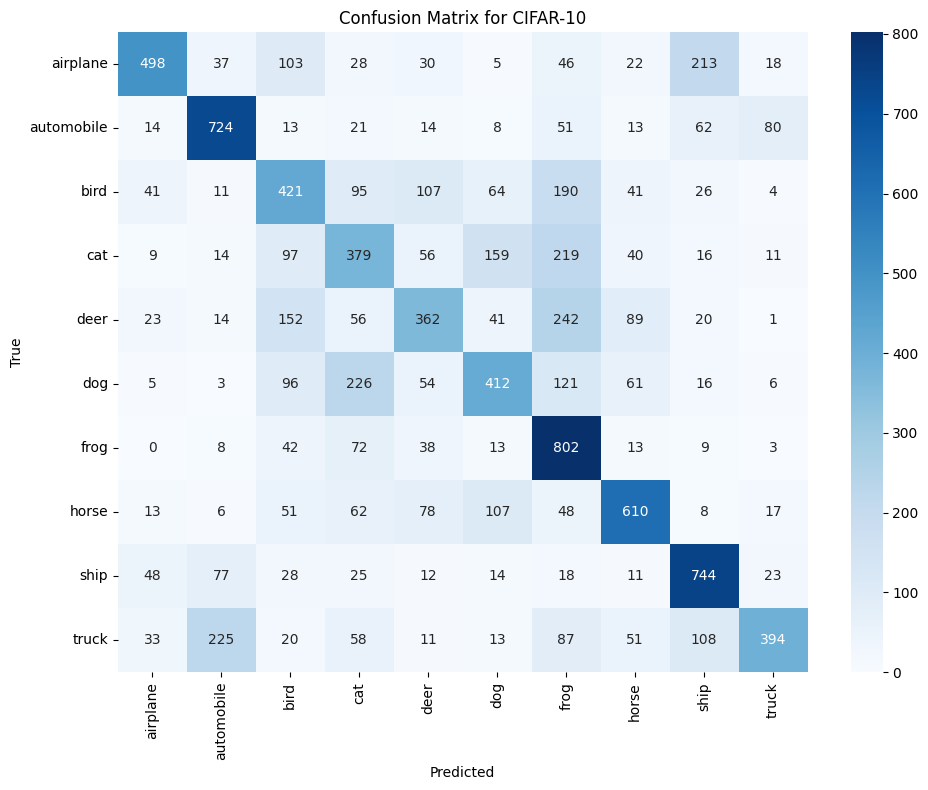

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Gather predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        # Move input data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Move predictions and labels back to CPU for numpy conversion
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot with labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.tight_layout()
plt.show()

#### What can you say about the CNN's performance? What does it do well? Where does it make mistakes?

## Recurrent Neural Networks (RNNs)

RNNs represent a powerful class of neural networks specifically designed to model sequential data by maintaining an internal memory. Unlike traditional feedforward neural networks, which process each input independently, RNNs incorporate feedback connections that allow information to persist across time steps. This unique architecture makes RNNs particularly well-suited for tasks involving sequential or temporal data, such as natural language processing, speech recognition, time series forecasting, and music generation.

### Key Components:

* Input layer: Receives the current data point in the sequence
* Hidden state: Acts as the network's "memory," updated at each time step
* Output layer: Produces predictions based on the current hidden state
* Recurrent connections: Allow information to flow between time steps

![RNN Architectures](images/rnn_statelayers.png)

### Types of RNNs
RNNs come in several configurations to address different sequence processing needs:

* One-to-One: Standard feedforward neural network (not truly recurrent)
* One-to-Many: Single input produces a sequence (e.g., image captioning)
* Many-to-One: Sequence input produces a single output (e.g., sentiment analysis)
* Many-to-Many: Sequence input produces sequence output (e.g., machine translation)
    * Synchronized: Output at each time step (e.g., POS tagging)
    * Encoder-Decoder: Full input sequence processed before generating outputs (e.g., translation)

### Training RNNs
RNNs are trained using Backpropagation Through Time (BPTT), an extension of the standard backpropagation algorithm that unfolds the recurrent network through time to compute gradients.

#### Challenges in Training
* Vanishing Gradients: One of the most significant challenges in training RNNs is the vanishing gradient problem. During backpropagation, gradients are multiplied by weight matrices repeatedly as they flow backward through time steps. If these values are small (< 1), the gradient diminishes exponentially, making it difficult for the network to learn long-term dependencies.
* Exploding Gradients: Conversely, if gradient values are large (> 1), they can grow exponentially during backpropagation, causing training instability. This is known as the exploding gradient problem and often results in numerical overflow or model divergence.

To address these challenges, practitioners employ several techniques:
* Gradient clipping: Limiting gradient magnitudes to prevent explosion
* Careful weight initialization: Using specialized initialization methods
* Advanced architectures: Employing LSTM or GRU cells (discussed below)
* Skip connections: Adding direct paths between distant time steps

### References:
* Image source: [IBM Developer RNN Deep Dive](https://developer.ibm.com/learningpaths/supervised-deep-learning/recurrent-neural-networks/introduction-recurrent-neural-networks/)
* [DataCamp Video on RNNs ~5 minutes](https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/sequences-recurrent-neural-networks?ex=4)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        
        # Convert input to embeddings
        embedded = self.embedding(x)
        
        # Process through RNN
        output, hidden = self.rnn(embedded, hidden)
        
        # Reshape for fully connected layer
        output = output.reshape(-1, self.hidden_size)
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        # Create hidden states on the same device as the model
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

# Training function
def train(model, data, seq_length, batch_size, epochs, lr=0.001):
    model.to(device)  # Move model to GPU if available
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        hidden = None
        total_loss = 0
        
        # Create batches
        n_batches = len(data) // (seq_length * batch_size)
        data_tensor = torch.tensor(data[:n_batches * seq_length * batch_size]).long().to(device)
        data_tensor = data_tensor.view(batch_size, -1)
        
        for i in range(0, data_tensor.size(1) - seq_length, seq_length):
            # Get input and target sequences
            inputs = data_tensor[:, i:i+seq_length]
            targets = data_tensor[:, i+1:i+seq_length+1]
            
            # Forward pass
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs, targets.reshape(-1))
            
            # Detach hidden state to prevent backpropagation through entire history
            hidden = (hidden[0].detach(), hidden[1].detach())
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)  # Gradient clipping
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/n_batches:.4f}")

# Generate text function
def generate_text(model, chars, char_to_idx, idx_to_char, seed_text, gen_length=200, temperature=0.8):
    model.eval()
    
    # Convert seed text to indices
    seed_idx = [char_to_idx[c] for c in seed_text]
    input_seq = torch.tensor([seed_idx]).long().to(device)
    
    hidden = None
    generated_text = seed_text
    
    # Generate new characters
    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(gen_length):
            output, hidden = model(input_seq, hidden)
            
            # Apply temperature to make sampling more/less conservative
            output = output / temperature
            
            # Sample from the predicted distribution
            probs = torch.softmax(output[-1], dim=0).cpu().numpy()
            next_char_idx = np.random.choice(len(chars), p=probs)
            
            # Add to generated text
            generated_text += idx_to_char[next_char_idx]
            
            # Update input sequence
            input_seq = torch.tensor([[next_char_idx]]).long().to(device)
    
    return generated_text

# Running it with your own text

f = open("data/fairy_tales.txt","r",encoding="utf-8")
text = f.read()

# Create character mappings
chars = sorted(list(set(text)))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}

# Convert text to indices
data = [char_to_idx[c] for c in text]

# Initialize model
model = CharRNN(
    input_size=len(chars),
    hidden_size=128,
    output_size=len(chars),
    n_layers=2
).to(device)

# Train model
train(model, data, seq_length=50, batch_size=32, epochs=5)

# Generate text
generated = generate_text(
    model, chars, char_to_idx, idx_to_char,
    seed_text="The", gen_length=500
)
print(generated)


Using device: cuda
Epoch 1, Loss: 1.5251
Epoch 2, Loss: 1.3190
Epoch 3, Loss: 1.2767
Epoch 4, Loss: 1.2550
Epoch 5, Loss: 1.2415
Thee rose ugly as she went out, however so handsomely.
"You cannot take a girly."
The wine put his might hand up something when the Kid may be going to speed if he had forgetted the door sing from remember man entirely more among the golden room with the permiets, standing in an a bot of a familiar and windows and king with the courtesement, and sat day of drinking.
“Books that so much to tell you and he last pet man in the solest man’s brothers and the peasant;” Mr. Palancholy seemed far up at the


### Try it out!

Start with few epochs to get an idea of the time training will require. Try it with different numbers of epochs for training and different input files. In the `data` folder, we've provided files with fairy tales, Shakespeare, and Bob Dylan. How do they compare? What are some other texts you can try to train on?

This is also a reminder of the Garbage In, Garbage Out principle. You can easily see the impact your training data has on the output.

## Long Short-Term Memory Networks (LSTMs)

LSTMs represent a powerful and sophisticated variant of Recurrent Neural Networks (RNNs) specifically engineered to overcome the limitations of standard RNNs. LSTMs have become the backbone of numerous sequence modeling applications, from natural language processing to time series forecasting.

We saw above that standard RNNs suffer from fundamental limitations when processing long sequences:

* Vanishing Gradient Problem: During backpropagation through time, gradients tend to diminish exponentially as they flow backward through many time steps, preventing the network from learning long-range dependencies.
* Exploding Gradient Problem: Conversely, gradients can also grow uncontrollably large, causing unstable learning and parameter updates.
* Short-term Memory: Due to these gradient issues, standard RNNs effectively have a limited "memory span," typically capturing dependencies over only 5-10 time steps.

LSTMs address these challenges through a meticulously designed cell structure that maintains a cell state (long-term memory) and controls information flow using specialized gating mechanisms.

### Key Components:
* Cell State (C<sub>t</sub>): The central component that acts as a conveyor belt of information flowing through the entire sequence, allowing information to traverse many time steps with minimal alteration.
* Hidden State (H<sub>t</sub>): The output state that captures information relevant for the current prediction.
* Gates: Three specialized neural networks that regulate information flow:
    * Forget Gate (F<sub>t</sub>): Determines what information to discard from the cell state
    * Input Gate (I<sub>t</sub>): Controls what new information to store in the cell state
    * Output Gate (O<sub>t</sub>): Filters the cell state to produce the hidden state

![LSTM Model](images/lstm_model.png)

### LSTM Forward Pass
The LSTM forward pass is the process of information flowing through the LSTM cell at each time step.

1. The Forget Gate Decision:
    * First, the LSTM looks at the current input and the previous hidden state (what it "remembered" from processing earlier parts of the sequence). It then decides what information from the old cell state should be thrown away:
        * Think of this as the LSTM asking: "What's no longer relevant from what I've been remembering?"
2. The Input Gate Process:
    * a. Input Gate: The LSTM decides which new information is worth storing:
        * Like asking: "What new information should I pay attention to?" For example, in text prediction, this might recognize that a proper noun just appeared, flagging it as important information.
    * b. Candidate Values: The LSTM creates potential new information to add to the cell state:
        * Like creating new memories based on what it's currently seeing. These are the actual values that might be added to the long-term memory.
3. Updating the Cell State:
This is where the magic happens. The LSTM updates its long-term memory (cell state):
    * a. It first erases information that the forget gate flagged as no longer needed.
    * b. Then it adds the new information that the input gate decided was important.
        * This is similar to updating your shopping list – crossing off items you've already bought (forget gate) and adding new items you just remembered you need (input gate).
4. The Output Gate Decision
    * Finally, the LSTM decides what information to output:
        * It creates a filtered version of the cell state based on what's relevant for the current output.
            * Think of it as asking: "What parts of my memory are relevant for answering right now?" For instance, in a conversation model, even though the LSTM remembers the entire context, it might focus only on information needed to answer the current question.

The beauty of the LSTM architecture is that it can selectively maintain information over many time steps, allowing it to "remember" important context from much earlier in a sequence while ignoring irrelevant details. This ability to manage information flow is what makes LSTMs so effective for processing sequential data like text, time series, or speech.

### References:
* Image Source: [Medium's Explanation of LSTM](https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c)
* [DataCamp video on LSTM ~4 minutes](https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/sequences-recurrent-neural-networks?ex=7)

### Practical Example: Time Series Prediction with LSTMs
Let's implement a complete LSTM model for time series prediction using PyTorch:

Using device: cuda
Fetching AAPL stock data for the past 5y...
Fetched 1257 days of AAPL data


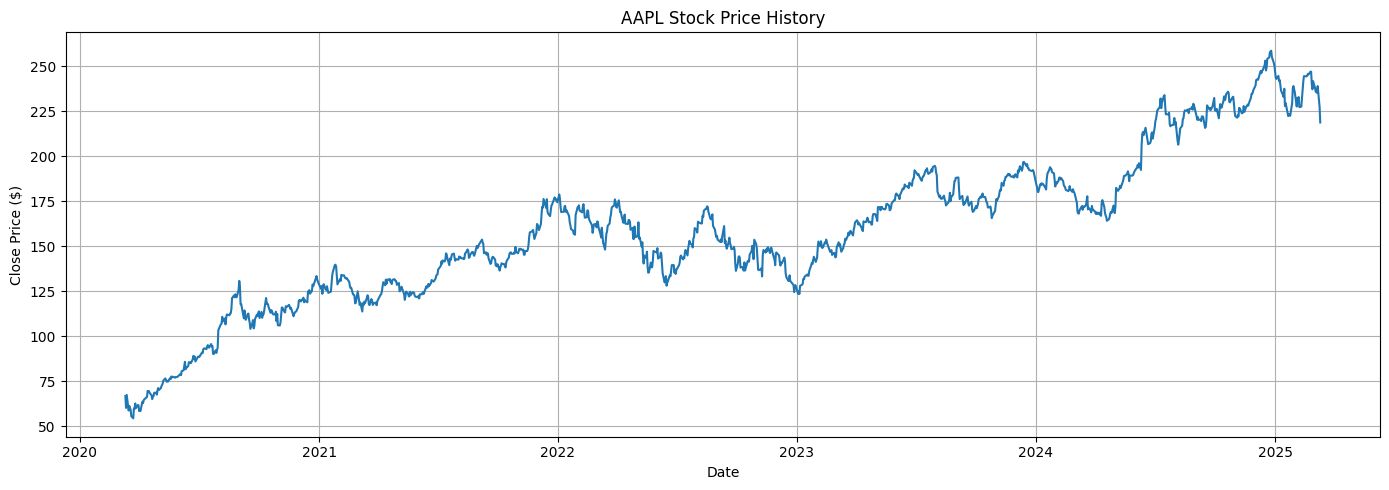

Training set size: 981, Test set size: 246
Starting training...
Epoch [1/100], Train Loss: 0.0685, Val Loss: 0.0632
Epoch [10/100], Train Loss: 0.0010, Val Loss: 0.0014
Epoch [20/100], Train Loss: 0.0008, Val Loss: 0.0015
Epoch [30/100], Train Loss: 0.0008, Val Loss: 0.0015
Epoch [40/100], Train Loss: 0.0007, Val Loss: 0.0013
Epoch [50/100], Train Loss: 0.0007, Val Loss: 0.0016
Epoch [60/100], Train Loss: 0.0008, Val Loss: 0.0014
Epoch [70/100], Train Loss: 0.0007, Val Loss: 0.0014
Epoch [80/100], Train Loss: 0.0007, Val Loss: 0.0014
Epoch [90/100], Train Loss: 0.0007, Val Loss: 0.0015
Epoch [100/100], Train Loss: 0.0007, Val Loss: 0.0015


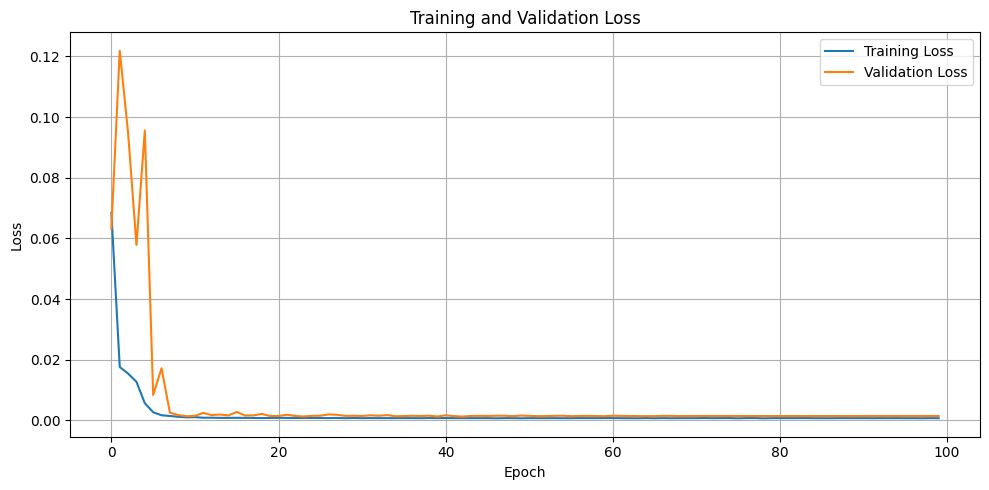

Making predictions...
Test RMSE: $7.80
Test MAE: $6.33
Test MAPE: 2.86%


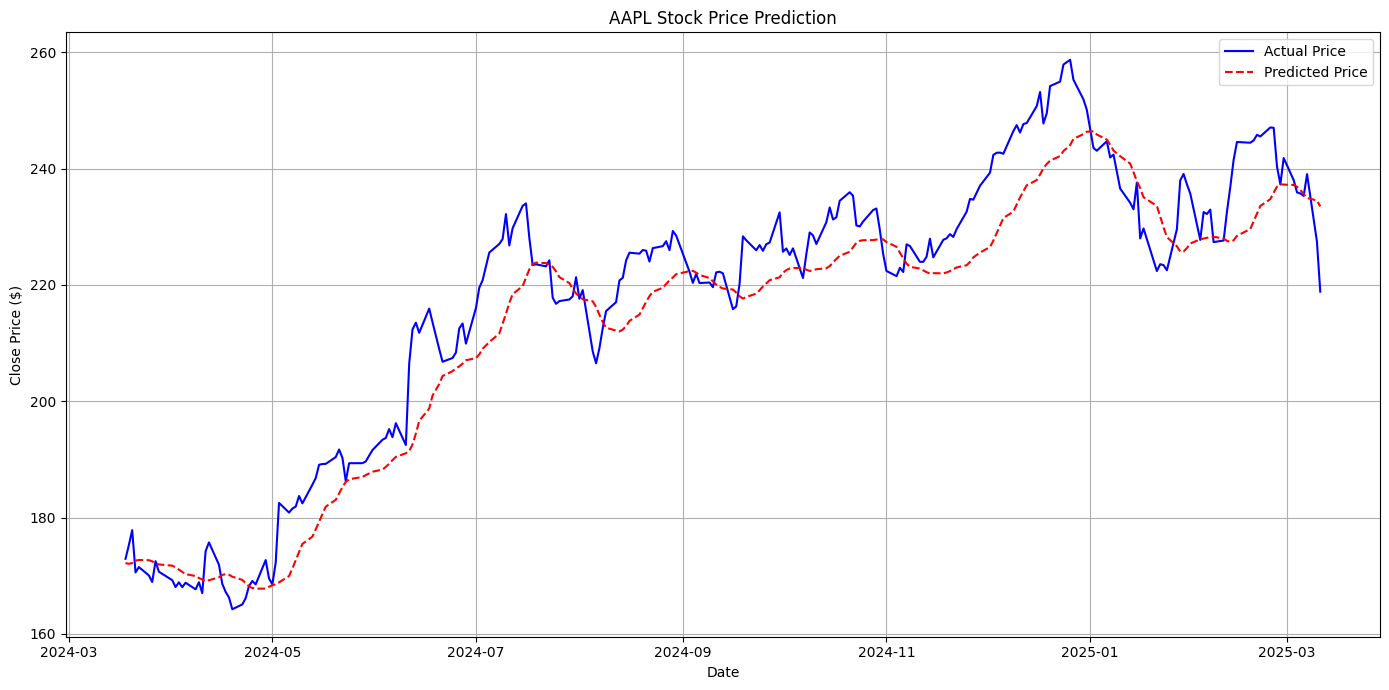

Model saved successfully

Predicted Close price for AAPL on 2025-03-12: $231.73


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index into the final output sequence
        out = self.fc(out[:, -1, :]) 
        return out

# Fetch stock data
def get_stock_data(ticker='AAPL', period='5y'):
    """
    Fetch stock data from Yahoo Finance
    
    Args:
        ticker (str): Stock ticker symbol
        period (str): Time period to fetch (e.g., '1y', '5y')
        
    Returns:
        pd.DataFrame: Stock price data
    """
    print(f"Fetching {ticker} stock data for the past {period}...")
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    
    # Check if data is empty
    if df.empty:
        raise ValueError(f"No data found for ticker {ticker}")
        
    print(f"Fetched {len(df)} days of {ticker} data")
    return df

# Create sequences for training
def create_sequences(data, seq_length):
    """
    Create sequences of data for LSTM training
    
    Args:
        data (np.array): Input data
        seq_length (int): Number of time steps in each sequence
        
    Returns:
        tuple: (X, y) where X is the input sequences and y is the target values
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Main execution
def main():
    # Model settings and hyperparameters
    ticker = 'AAPL'             # Stock ticker
    feature = 'Close'           # Price feature to predict
    lookback = 30               # Number of days to look back
    train_split = 0.8           # Proportion of data for training
    batch_size = 64             # Batch size
    learning_rate = 0.001       # Learning rate
    num_epochs = 100            # Number of training epochs
    hidden_dim = 64             # Hidden dimension of LSTM
    num_layers = 2              # Number of LSTM layers
    dropout = 0.2               # Dropout rate
    
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Fetch and prepare data
    try:
        df = get_stock_data(ticker=ticker, period='5y')
        
        # Extract the closing prices
        prices = df[feature].values.reshape(-1, 1)
        
        # Plot the stock price history
        plt.figure(figsize=(14, 5))
        plt.plot(df.index, df[feature])
        plt.title(f'{ticker} Stock Price History')
        plt.xlabel('Date')
        plt.ylabel(f'{feature} Price ($)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('stock_history.png')
        plt.show()
        
        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        prices_scaled = scaler.fit_transform(prices)
        
        # Create sequences
        X, y = create_sequences(prices_scaled, lookback)
        
        # Convert to PyTorch tensors and move to device
        X_tensor = torch.FloatTensor(X).to(device)
        y_tensor = torch.FloatTensor(y).to(device)
        
        # Split data into train and test sets
        train_size = int(len(X) * train_split)
        X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
        y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]
        
        print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
        
        # Initialize model and move to device
        input_dim = 1  # Single feature (closing price)
        output_dim = 1  # Predicting single value (next day's closing price)
        
        model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
        
        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        
        # Create DataLoader for batch processing
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Lists to store training progress
        train_losses = []
        val_losses = []
        
        # Train the model
        print("Starting training...")
        model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                # Forward pass
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                epoch_loss += loss.item()
            
            # Average training loss for the epoch
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test)
                val_loss = criterion(val_outputs, y_test)
                val_losses.append(val_loss.item())
            model.train()
            
            # Learning rate scheduler step
            scheduler.step(val_loss)
            
            if (epoch+1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}')
        
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('training_loss.png')
        plt.show()
        
        # Make predictions
        print("Making predictions...")
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test)
        
        # Move tensors back to CPU for numpy conversion and plotting
        test_predictions = test_predictions.cpu().numpy()
        y_test_actual = y_test.cpu().numpy()
        
        # Inverse transform predictions and actual values
        test_predictions = scaler.inverse_transform(test_predictions)
        y_test_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1))
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
        mae = mean_absolute_error(y_test_actual, test_predictions)
        mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100
        
        print(f'Test RMSE: ${rmse:.2f}')
        print(f'Test MAE: ${mae:.2f}')
        print(f'Test MAPE: {mape:.2f}%')
        
        # Plot results
        plt.figure(figsize=(14, 7))
        
        # Get test period dates
        test_dates = df.index[train_size+lookback:train_size+lookback+len(test_predictions)]
        
        # Plot actual vs predicted
        plt.plot(test_dates, y_test_actual, label='Actual Price', color='blue')
        plt.plot(test_dates, test_predictions, label='Predicted Price', color='red', linestyle='--')
        plt.title(f'{ticker} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel(f'{feature} Price ($)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('prediction_results.png')
        plt.show()
        
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler,
            'lookback': lookback,
            'feature': feature,
            'ticker': ticker
        }, 'stock_lstm_model.pth')
        print("Model saved successfully")
        
        # Predict the next day
        latest_data = prices_scaled[-lookback:].reshape(1, lookback, 1)
        latest_data_tensor = torch.FloatTensor(latest_data).to(device)
        
        with torch.no_grad():
            next_day_pred = model(latest_data_tensor).cpu().numpy()
            next_day_pred = scaler.inverse_transform(next_day_pred)[0][0]
        
        last_date = df.index[-1]
        next_business_day = last_date + timedelta(days=1)
        while next_business_day.weekday() > 4:  # Skip weekend
            next_business_day += timedelta(days=1)
            
        print(f"\nPredicted {feature} price for {ticker} on {next_business_day.date()}: ${next_day_pred:.2f}")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

### Try it out!

* Adjust the `ticker` variable to analyze different stocks (e.g., 'MSFT', 'GOOGL').
* The `feature` variable allows you to predict different aspects (e.g., 'Open', 'High', 'Low', 'Volume').
* You can change the `lookback` variable to adjust how many days the model considers for each prediction.
* Adjust other hyperparameters to see if you can improve the results.

## Generative Adversarial Networks (GANs)

Generative Adversarial Networks represent a breakthrough in machine learning, introducing a framework where two neural networks compete to produce increasingly realistic outputs.

At their heart, GANs operate on a simple yet powerful principle: two networks locked in a game-theoretic duel. The generator network attempts to create data indistinguishable from reality, while the discriminator network works to detect the generated fakes. This adversarial process drives both networks to improve continuously.

GANs excel at capturing complex, high-dimensional distributions that other generative models struggle with. Their ability to generate highly realistic content has revolutionized fields including computer vision, content creation, and data augmentation.

### Key Components
1. Generator: transforms random noise into synthetic data (images, text, etc.)
2. Discriminator: evaluates both real and generated data, classifying each as either authentic or fake
3. Training Loop: creates a feedback mechanism where:
    * The discriminator improves at detecting generated content.
    * The generator learns to produce more convincing outputs.
    * Both networks evolve toward an equilibrium where generated data becomes indistinguishable from real data.

![GAN Model](images/gan_model.png)

### Common Challenges
Despite their power, GANs present distinct challenges:
* Training instability and mode collapse
* Difficulty achieving convergence
* Quantitative evaluation complexity
* High computational requirements

Recent advances have addressed many early limitations through architectural innovations like StyleGAN, conditional GANs, and progressive growing techniques. These improvements have enabled remarkable applications from photorealistic face generation to sophisticated image-to-image translation.

### References:
* Image Source: [Medium's Understanding a GAN](https://devshahs.medium.com/build-a-gan-with-me-step-by-step-guide-on-understanding-a-gan-from-scratch-28654a2a5cdd)
* [DataCamp video on GANs ~4 minutes](https://campus.datacamp.com/courses/deep-learning-for-images-with-pytorch/image-generation-with-gans?ex=1)
_________

GANs consist of two neural networks, a generator and a discriminator, that compete against each other in a unique training process. The generator tries to create realistic data samples, while the discriminator tries to distinguish between real and generated samples. This adversarial process pushes both networks to improve, leading to the generation of highly realistic data.

### Key Components

*   **Generator:** Takes random noise as input and generates data samples.
*   **Discriminator:** Takes data samples (real or generated) as input and tries to classify them as real or fake.
*   **Adversarial Training:** The generator and discriminator are trained in tandem, with the generator trying to fool the discriminator and the discriminator trying to avoid being fooled.

### Practical Example: Image Generation with GANs

Let's build a simple GAN to generate images from the MNIST dataset using PyTorch.


Using device: cuda
Epoch: 1, Batch: 0, D Loss: 1.455492377281189, G Loss: 0.6777931451797485
Epoch: 1, Batch: 200, D Loss: 0.15434987843036652, G Loss: 2.74220871925354
Epoch: 1, Batch: 400, D Loss: 1.6160858869552612, G Loss: 11.411611557006836
Epoch: 1, Batch: 600, D Loss: 0.09411665797233582, G Loss: 4.349053382873535
Epoch: 1, Batch: 800, D Loss: 0.43567344546318054, G Loss: 7.264512062072754


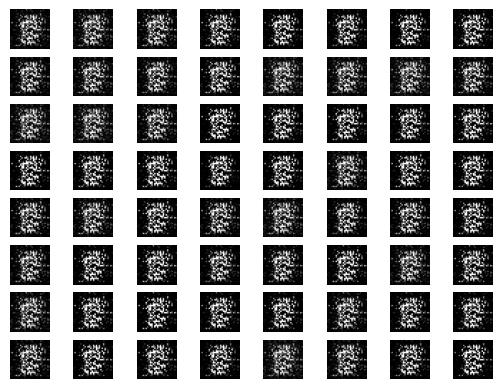

Epoch: 2, Batch: 0, D Loss: 0.12564486265182495, G Loss: 13.184252738952637
Epoch: 2, Batch: 200, D Loss: 0.036558158695697784, G Loss: 5.664865970611572
Epoch: 2, Batch: 400, D Loss: 0.05589183792471886, G Loss: 6.494034290313721
Epoch: 2, Batch: 600, D Loss: 0.0025990228168666363, G Loss: 6.798254489898682
Epoch: 2, Batch: 800, D Loss: 0.00985836423933506, G Loss: 6.703708648681641


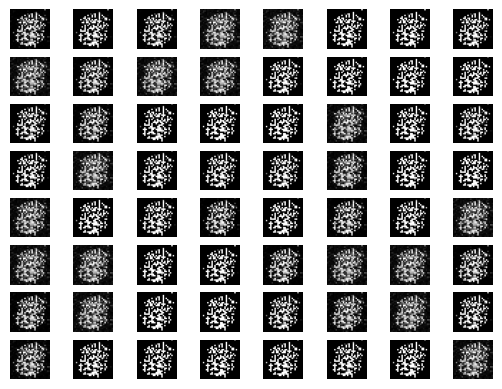

Epoch: 3, Batch: 0, D Loss: 0.02762679010629654, G Loss: 7.284787178039551
Epoch: 3, Batch: 200, D Loss: 0.9092023372650146, G Loss: 3.8938050270080566
Epoch: 3, Batch: 400, D Loss: 3.621030807495117, G Loss: 7.141059398651123
Epoch: 3, Batch: 600, D Loss: 0.2143310308456421, G Loss: 13.517476081848145
Epoch: 3, Batch: 800, D Loss: 0.3381016254425049, G Loss: 6.05445671081543


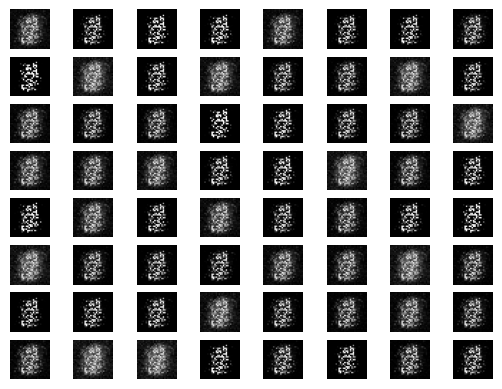

Epoch: 4, Batch: 0, D Loss: 1.0273268222808838, G Loss: 3.768892526626587
Epoch: 4, Batch: 200, D Loss: 0.17788058519363403, G Loss: 8.12196159362793
Epoch: 4, Batch: 400, D Loss: 0.0072427475824952126, G Loss: 6.248867034912109
Epoch: 4, Batch: 600, D Loss: 0.008776950649917126, G Loss: 4.936164855957031
Epoch: 4, Batch: 800, D Loss: 0.033810243010520935, G Loss: 5.874821662902832


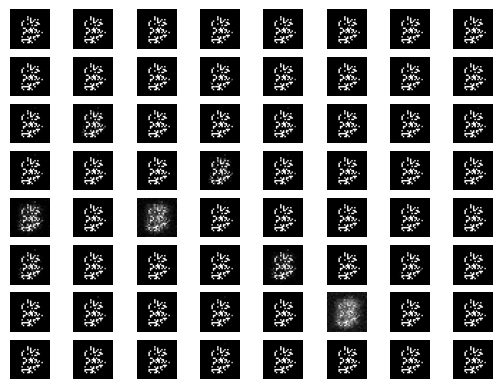

Epoch: 5, Batch: 0, D Loss: 0.04520982503890991, G Loss: 9.455390930175781
Epoch: 5, Batch: 200, D Loss: 0.47974637150764465, G Loss: 13.55661392211914
Epoch: 5, Batch: 400, D Loss: 1.7308266162872314, G Loss: 2.5323405265808105
Epoch: 5, Batch: 600, D Loss: 0.38044312596321106, G Loss: 6.3680500984191895
Epoch: 5, Batch: 800, D Loss: 0.675484299659729, G Loss: 8.620936393737793


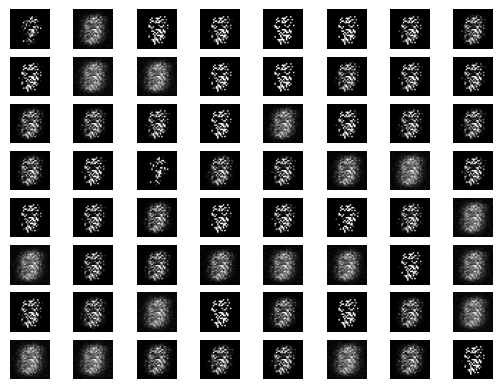

Epoch: 6, Batch: 0, D Loss: 0.36618906259536743, G Loss: 9.654237747192383
Epoch: 6, Batch: 200, D Loss: 1.0374797582626343, G Loss: 3.0644936561584473
Epoch: 6, Batch: 400, D Loss: 0.021321820095181465, G Loss: 5.331872463226318
Epoch: 6, Batch: 600, D Loss: 0.0022924658842384815, G Loss: 6.656007289886475
Epoch: 6, Batch: 800, D Loss: 0.12304572016000748, G Loss: 4.7585954666137695


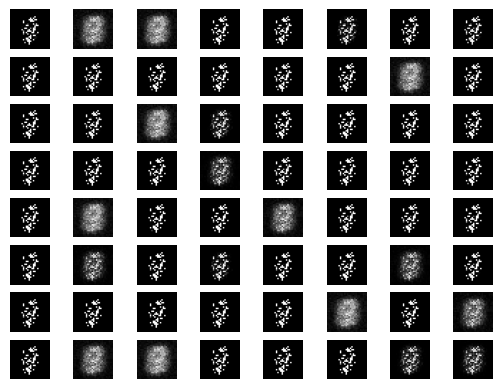

Epoch: 7, Batch: 0, D Loss: 0.19883835315704346, G Loss: 4.556687831878662
Epoch: 7, Batch: 200, D Loss: 1.459926962852478, G Loss: 1.8386906385421753
Epoch: 7, Batch: 400, D Loss: 0.8107024431228638, G Loss: 3.4224634170532227
Epoch: 7, Batch: 600, D Loss: 2.096977472305298, G Loss: 4.700725555419922
Epoch: 7, Batch: 800, D Loss: 1.7047277688980103, G Loss: 6.898359775543213


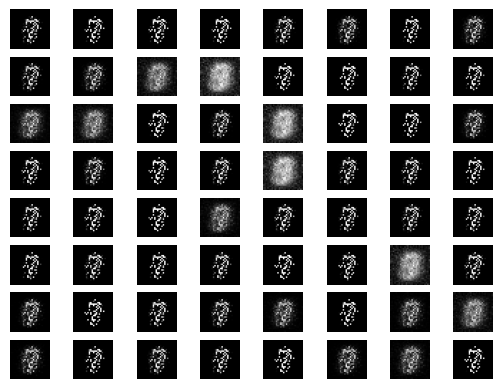

Epoch: 8, Batch: 0, D Loss: 1.7916340827941895, G Loss: 5.3462138175964355
Epoch: 8, Batch: 200, D Loss: 1.2904858589172363, G Loss: 1.5603485107421875
Epoch: 8, Batch: 400, D Loss: 1.7782206535339355, G Loss: 2.9552392959594727
Epoch: 8, Batch: 600, D Loss: 0.7634899616241455, G Loss: 5.240593910217285
Epoch: 8, Batch: 800, D Loss: 0.7524867057800293, G Loss: 2.0144786834716797


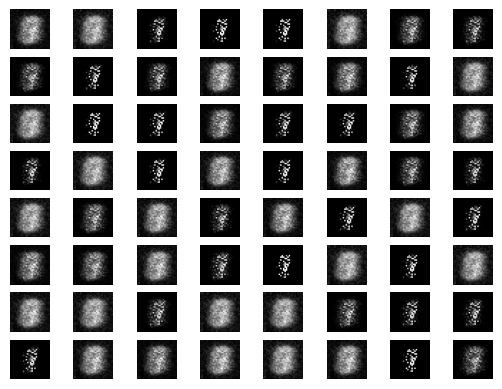

Epoch: 9, Batch: 0, D Loss: 0.9594401717185974, G Loss: 3.4567971229553223
Epoch: 9, Batch: 200, D Loss: 1.8498659133911133, G Loss: 3.1636431217193604
Epoch: 9, Batch: 400, D Loss: 1.078244686126709, G Loss: 2.148634910583496
Epoch: 9, Batch: 600, D Loss: 0.6540650725364685, G Loss: 1.5043549537658691
Epoch: 9, Batch: 800, D Loss: 1.281003475189209, G Loss: 2.2514703273773193


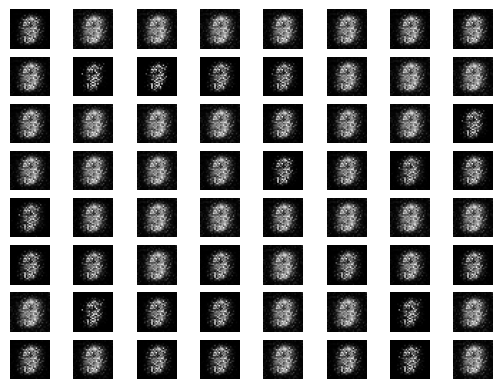

Epoch: 10, Batch: 0, D Loss: 0.6308671832084656, G Loss: 2.4413232803344727
Epoch: 10, Batch: 200, D Loss: 0.27200525999069214, G Loss: 4.848164081573486
Epoch: 10, Batch: 400, D Loss: 0.6999552845954895, G Loss: 4.047412872314453
Epoch: 10, Batch: 600, D Loss: 0.36929237842559814, G Loss: 4.2743024826049805
Epoch: 10, Batch: 800, D Loss: 0.99898362159729, G Loss: 3.0106124877929688


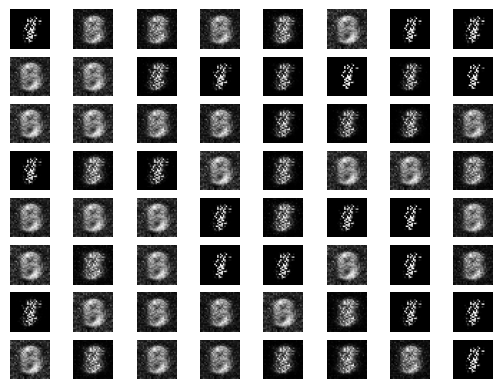

Epoch: 11, Batch: 0, D Loss: 0.6133484840393066, G Loss: 7.193669319152832
Epoch: 11, Batch: 200, D Loss: 0.2762462794780731, G Loss: 6.469240188598633
Epoch: 11, Batch: 400, D Loss: 1.214066505432129, G Loss: 4.770283222198486
Epoch: 11, Batch: 600, D Loss: 0.7329221963882446, G Loss: 4.760053634643555
Epoch: 11, Batch: 800, D Loss: 1.137953519821167, G Loss: 1.9924606084823608


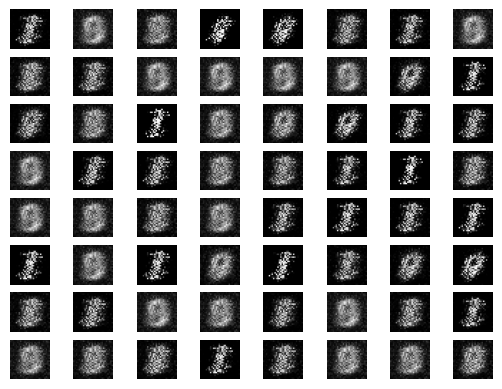

Epoch: 12, Batch: 0, D Loss: 1.4320893287658691, G Loss: 4.900951385498047
Epoch: 12, Batch: 200, D Loss: 0.7870827913284302, G Loss: 3.6213979721069336
Epoch: 12, Batch: 400, D Loss: 0.7592430114746094, G Loss: 2.8796184062957764
Epoch: 12, Batch: 600, D Loss: 1.340409278869629, G Loss: 3.8166189193725586
Epoch: 12, Batch: 800, D Loss: 0.5771282911300659, G Loss: 2.1669669151306152


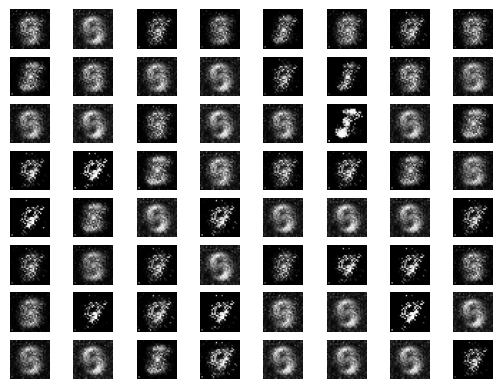

Epoch: 13, Batch: 0, D Loss: 1.267572045326233, G Loss: 3.431033134460449
Epoch: 13, Batch: 200, D Loss: 0.5931450724601746, G Loss: 2.9452731609344482
Epoch: 13, Batch: 400, D Loss: 0.28789058327674866, G Loss: 3.859600305557251
Epoch: 13, Batch: 600, D Loss: 0.47189509868621826, G Loss: 3.190495014190674
Epoch: 13, Batch: 800, D Loss: 0.26336970925331116, G Loss: 3.9839224815368652


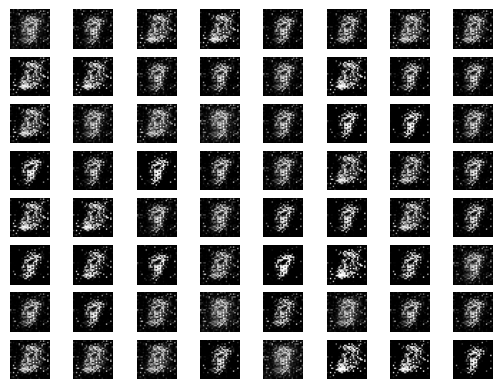

Epoch: 14, Batch: 0, D Loss: 0.7828223705291748, G Loss: 4.6581268310546875
Epoch: 14, Batch: 200, D Loss: 0.2642877995967865, G Loss: 5.158339500427246
Epoch: 14, Batch: 400, D Loss: 0.3305922746658325, G Loss: 4.724695682525635
Epoch: 14, Batch: 600, D Loss: 0.5120589137077332, G Loss: 4.5427727699279785
Epoch: 14, Batch: 800, D Loss: 0.2585000991821289, G Loss: 6.561775207519531


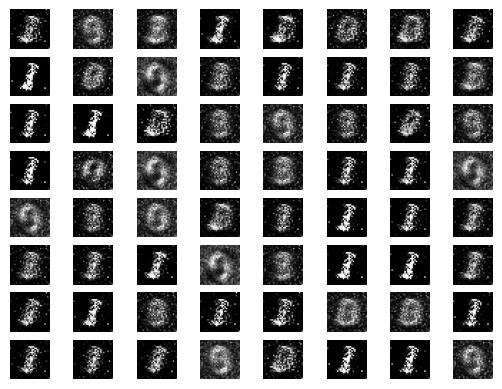

Epoch: 15, Batch: 0, D Loss: 1.1961044073104858, G Loss: 6.754305839538574
Epoch: 15, Batch: 200, D Loss: 0.09346427768468857, G Loss: 5.748980522155762
Epoch: 15, Batch: 400, D Loss: 0.1799720823764801, G Loss: 3.9749841690063477
Epoch: 15, Batch: 600, D Loss: 0.47735166549682617, G Loss: 2.7734079360961914
Epoch: 15, Batch: 800, D Loss: 0.3438592851161957, G Loss: 4.714149475097656


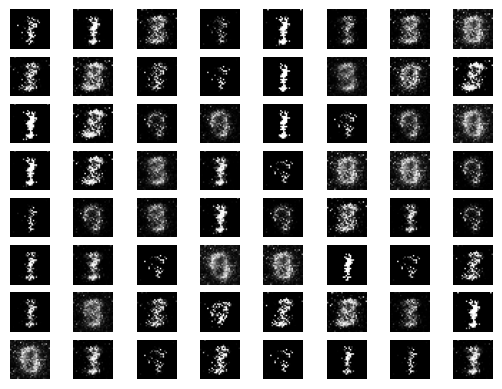

Epoch: 16, Batch: 0, D Loss: 0.41862794756889343, G Loss: 4.11139440536499
Epoch: 16, Batch: 200, D Loss: 0.6175340414047241, G Loss: 2.9694414138793945
Epoch: 16, Batch: 400, D Loss: 0.328353613615036, G Loss: 4.998989582061768
Epoch: 16, Batch: 600, D Loss: 0.9619279503822327, G Loss: 4.0318217277526855
Epoch: 16, Batch: 800, D Loss: 0.16775760054588318, G Loss: 3.773249626159668


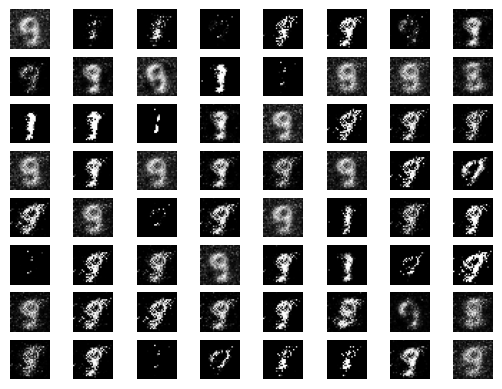

Epoch: 17, Batch: 0, D Loss: 0.3350553512573242, G Loss: 3.929917812347412
Epoch: 17, Batch: 200, D Loss: 0.34522193670272827, G Loss: 2.571092367172241
Epoch: 17, Batch: 400, D Loss: 1.0144896507263184, G Loss: 4.168035507202148
Epoch: 17, Batch: 600, D Loss: 0.5349981784820557, G Loss: 4.295069694519043
Epoch: 17, Batch: 800, D Loss: 0.5862231254577637, G Loss: 3.2780704498291016


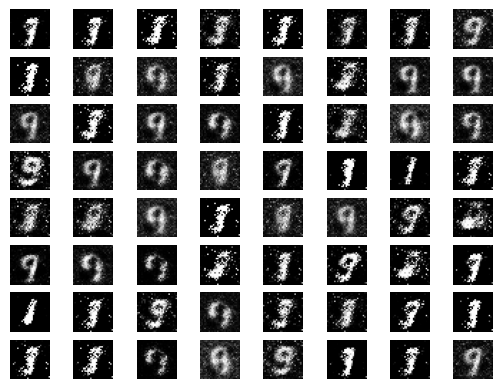

Epoch: 18, Batch: 0, D Loss: 0.8201627731323242, G Loss: 3.825791835784912
Epoch: 18, Batch: 200, D Loss: 0.5233708620071411, G Loss: 2.74605131149292
Epoch: 18, Batch: 400, D Loss: 0.3003603219985962, G Loss: 4.203719139099121
Epoch: 18, Batch: 600, D Loss: 0.572844386100769, G Loss: 2.280198574066162
Epoch: 18, Batch: 800, D Loss: 0.2787087857723236, G Loss: 3.9236466884613037


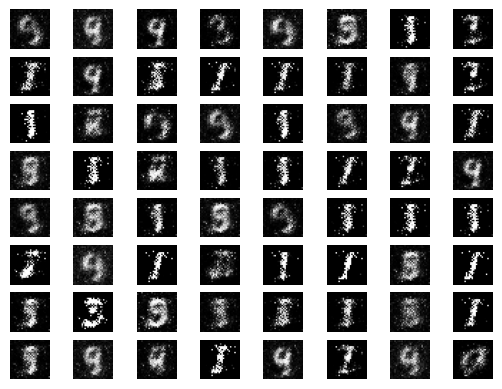

Epoch: 19, Batch: 0, D Loss: 0.506251871585846, G Loss: 3.7397711277008057
Epoch: 19, Batch: 200, D Loss: 0.36850351095199585, G Loss: 5.572635650634766
Epoch: 19, Batch: 400, D Loss: 0.3090174198150635, G Loss: 3.4033172130584717
Epoch: 19, Batch: 600, D Loss: 0.37920141220092773, G Loss: 4.759340763092041
Epoch: 19, Batch: 800, D Loss: 0.21910080313682556, G Loss: 2.5668375492095947


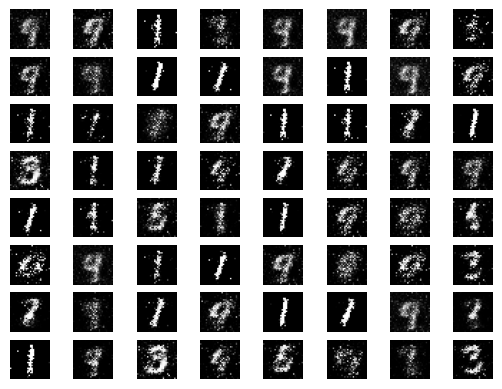

Epoch: 20, Batch: 0, D Loss: 0.31222736835479736, G Loss: 4.218493461608887
Epoch: 20, Batch: 200, D Loss: 0.37871524691581726, G Loss: 4.711136817932129
Epoch: 20, Batch: 400, D Loss: 0.48119160532951355, G Loss: 3.3110432624816895
Epoch: 20, Batch: 600, D Loss: 0.26018333435058594, G Loss: 4.756511688232422
Epoch: 20, Batch: 800, D Loss: 0.4765661358833313, G Loss: 3.544895648956299


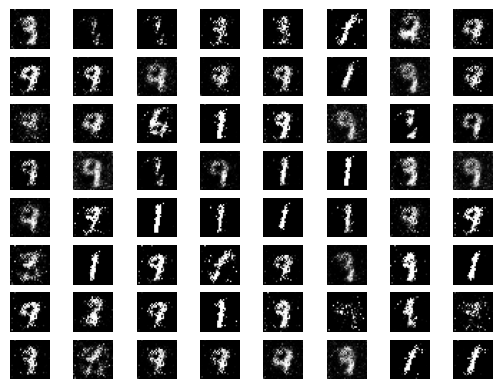

Finished Training


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
latent_dim = 100
image_size = 28 * 28
learning_rate = 0.0005
epochs = 20

# Initialize Generator and Discriminator
generator = Generator(latent_dim, image_size)
discriminator = Discriminator(image_size)

# move to device (gpu)
generator = Generator(latent_dim, image_size).to(device)
discriminator = Discriminator(image_size).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

# Training loop (simplified for brevity)
for epoch in range(epochs):
    for i, (images, _) in enumerate(trainloader):
        # Adversarial ground truths
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # Train Discriminator
        discriminator.zero_grad()
        real_images = images.view(images.size(0), -1).to(device)
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_real.backward()

        noise = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)  # Try to fool the discriminator
        g_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(f"Epoch: {epoch + 1}, Batch: {i}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # Generate and visualize some images (simplified for brevity)
    with torch.no_grad():
        noise = torch.randn(64, latent_dim).to(device)
        generated_images = generator(noise).view(64, 1, 28, 28).cpu()  # Move back to CPU for plotting
        for i in range(8):
            for j in range(8):
                plt.subplot(8, 8, i * 8 + j + 1)
                plt.imshow(generated_images[i * 8 + j].squeeze(), cmap='gray')
                plt.axis('off')
        plt.show()

print('Finished Training')


### Evaluation

Here, we started with 20 epochs and a learning rate of 0.0005. If you have the computing power and time! to spend, you can try reducing the learning rate and increasing the epochs. How do you think this model performs?

## Conclusion

In this workshop, we've explored a variety of powerful neural network architectures:

* CNNs: We saw how CNNs excel at processing images and extracting spatial hierarchies using convolutional and pooling layers.
* RNNs: We learned how RNNs handle sequential data by incorporating recurrent connections to maintain information about past inputs.
* LSTMs: We delved into LSTMs, a specialized type of RNN designed to address the vanishing gradient problem and capture long-term dependencies.
* GANs: We explored the fascinating world of GANs, where two networks (generator and discriminator) compete to generate realistic data.

We've not only covered the theory behind these architectures but also built practical examples using PyTorch, demonstrating their capabilities in image classification, text generation, time series prediction, and image generation.

This workshop provides a solid foundation for further exploration of these architectures and their applications. You can delve deeper into each architecture, experiment with different datasets and tasks, and explore advanced topics like transfer learning, attention mechanisms, and reinforcement learning.

The field of neural networks is constantly evolving, with new architectures and applications emerging rapidly. By understanding the fundamental principles and building hands-on experience, you'll be well-equipped to navigate this exciting landscape and contribute to the future of AI.